In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [4]:
dataset_train = pd.read_csv('Google_Stock_Price_Train.csv')

In [5]:
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [6]:
training_set = dataset_train.iloc[:, 1: 2].values

In [7]:
training_set.shape


(1258, 1)

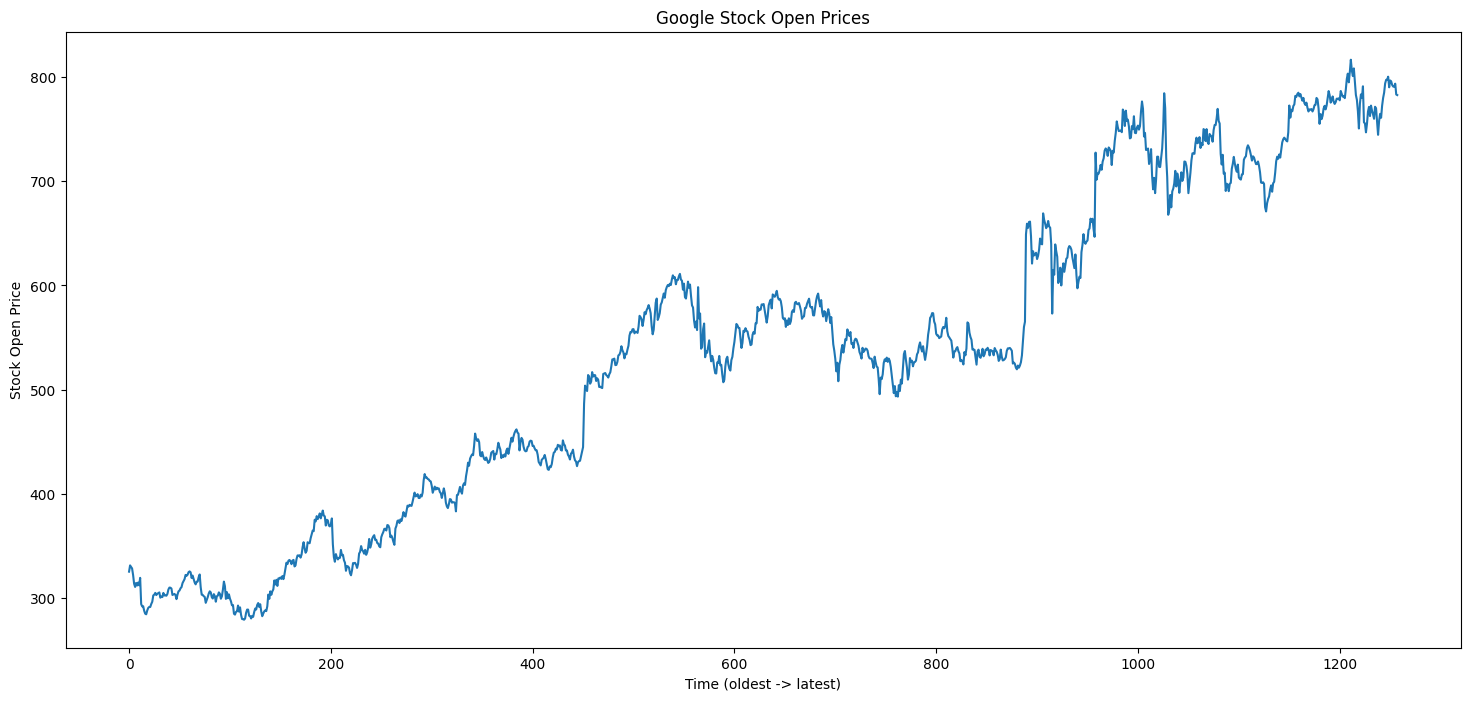

In [8]:
plt.figure(figsize=(18, 8))
plt.plot(dataset_train['Open'])
plt.title("Google Stock Open Prices")
plt.xlabel("Time (oldest -> latest)")
plt.ylabel("Stock Open Price")
plt.show()

In [9]:
import os
if os.path.exists('config.py'):
    print(1)
else:
    print(0)

0


In [10]:
sc = MinMaxScaler(feature_range = (0, 1))
#fit: get min/max of train data
training_set_scaled = sc.fit_transform(training_set)

In [11]:
X_train = []
y_train = []
for i in range(60, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-60: i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

In [12]:
X_train.shape

(1198, 60)

In [13]:
y_train.shape

(1198,)

In [14]:
X_train = np.reshape(X_train, newshape = 
                     (X_train.shape[0], X_train.shape[1], 1))

In [15]:
X_train.shape

(1198, 60, 1)

In [16]:
regressor = Sequential()
#add 1st lstm layer
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(rate = 0.2))

##add 2nd lstm layer: 50 neurons
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 3rd lstm layer
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(rate = 0.2))

##add 4th lstm layer
regressor.add(LSTM(units = 50, return_sequences = False))
regressor.add(Dropout(rate = 0.2))

##add output layer
regressor.add(Dense(units = 1))

In [17]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [18]:
regressor.fit(x = X_train, y = y_train, batch_size = 32, epochs = 100)

Epoch 1/100
38/38 [==============================] - 254s 231ms/step - loss: 0.0423
Epoch 2/100
38/38 [==============================] - 6s 149ms/step - loss: 0.0065
Epoch 3/100
38/38 [==============================] - 6s 154ms/step - loss: 0.0056
Epoch 4/100
38/38 [==============================] - 6s 149ms/step - loss: 0.0049
Epoch 5/100
38/38 [==============================] - 7s 178ms/step - loss: 0.0049
Epoch 6/100
38/38 [==============================] - 6s 149ms/step - loss: 0.0046
Epoch 7/100
38/38 [==============================] - 6s 146ms/step - loss: 0.0045
Epoch 8/100
38/38 [==============================] - 6s 146ms/step - loss: 0.0046
Epoch 9/100
38/38 [==============================] - 6s 147ms/step - loss: 0.0040
Epoch 10/100
38/38 [==============================] - 6s 171ms/step - loss: 0.0043
Epoch 11/100
38/38 [==============================] - 6s 149ms/step - loss: 0.0046
Epoch 12/100
38/38 [==============================] - 6s 146ms/step - loss: 0.0053
Epoch 13/10

In [19]:
dataset_test = pd.read_csv('Google_Stock_Price_Test.csv')

In [20]:
dataset_test.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [21]:
real_stock_price = dataset_test.iloc[:, 1: 2].values
real_stock_price.shape

(20, 1)

In [22]:
#By concatenating the 'Open' columns from the training and test datasets, 
#you create a single dataset containing historical data that will be used as input to your LSTM model.
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), 
                          axis = 0)
##use .values to make numpy array
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values

In [23]:
inputs = inputs.reshape(-1, 1)

#scale input
inputs = sc.transform(inputs)

In [24]:
len(inputs)

80

In [25]:
X_test = []
for i in range(60, len(inputs)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
#add dimension of indicator
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [26]:
X_test.shape

(20, 60, 1)

In [27]:
predicted_stock_price = regressor.predict(X_test)

1/1 [==============================] - 51s 51s/step


In [28]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

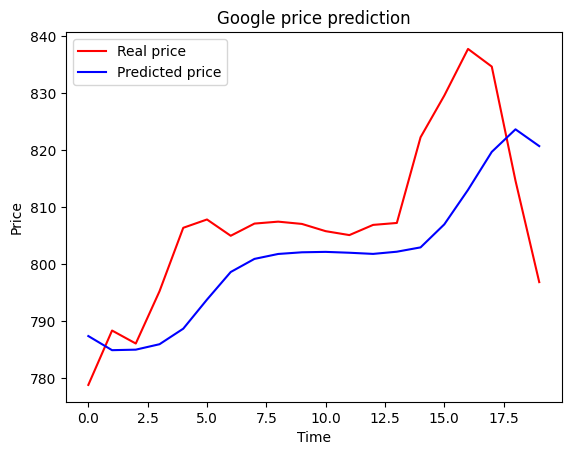

In [29]:
plt.plot(real_stock_price, color = 'red', label = 'Real price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted price')

plt.title('Google price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()